## Load libraries

In [143]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np

# Libraries to cluster data
from sklearn.mixture import BayesianGaussianMixture as BGM

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
from cluster_visualization_helper import visualize_cluster  # user-defined functions

# Libraries for evaluation
from sklearn import metrics

# Libraries for monitoring operation process
from tqdm import tqdm

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

## Import data

In [3]:
title_embeddings = np.load(OUTPUT_DIR + "title_embeddings.npy")

In [4]:
title_embeddings.shape

(18992, 300)

## Clustering data

### Bayesian Gaussian Mixture Model (BGM) 

In [5]:
X = title_embeddings

In [140]:
def build_bgm_model(X, n_components):
    """
    Build Bayesian Gaussian Mixture model

    Parameters:
    ----------
    X: data (N documents x K dimensions)
    n_components: maximum number of clusters
    weight_concentration_prior: Dirichlet alpha

    Returns:
    -------
    model: BGM model
    """

    model = BGM(
        n_components=n_components,
        random_state=SEED,
        verbose=3
    ).fit(X)

    return model

## Tuning hyperparameters

In [165]:
# Set up a range of components numbers to try
n_range = [10, 50, 100, 150, 200, 250, 300]
# n_range = range(100, 300, 50)

model_list = []

# Loop through the range and fit a model
pbar = tqdm(desc="Building BGM model", total=len(n_range))
for n in n_range:
    # Build model
    bgm_model = build_bgm_model(X, n)

    # Append the model to the respective lists
    model_list.append(bgm_model)
    pbar.update(1)
pbar.close()

Building BGM model:   0%|                                   | 0/4 [00:00<?, ?it/s]

Initialization 0
  Iteration 10	 time lapse 237.14289s	 ll change 362.16553
Initialization converged: True	 time lapse 324.72998s	 ll 51392112.98635


Building BGM model:  25%|██████▌                   | 1/4 [05:38<16:54, 338.23s/it]

Initialization 0
  Iteration 10	 time lapse 355.46333s	 ll change 218.27343
Initialization converged: True	 time lapse 658.87275s	 ll 67624301.33462


Building BGM model:  50%|█████████████             | 2/4 [16:58<17:58, 539.36s/it]

Initialization 0
  Iteration 10	 time lapse 480.48430s	 ll change 11517.26563
Initialization converged: True	 time lapse 915.23102s	 ll 83796761.94785


Building BGM model:  75%|███████████████████▌      | 3/4 [32:43<12:04, 724.80s/it]

Initialization 0
  Iteration 10	 time lapse 712.42489s	 ll change 604.37497
Initialization converged: True	 time lapse 953.40395s	 ll 99750881.75545


Building BGM model: 100%|██████████████████████████| 4/4 [49:13<00:00, 738.33s/it]


In [166]:
# Create empty lists to store evaluation metrics
score_list = []
# converge_list = []
weight_list = []
# lower_bound_list = []
silho_list = []

# Loop through the range and store evaluation metrics
pbar = tqdm(desc="Scoring BGM model", total=len(n_range))
for idx, n in enumerate(n_range):
    bgm_model = model_list[idx]
    score_list.append(bgm_model.score(X))
#     converge_list.append(bgm_model.converged_)
    weight_list.append(bgm_model.weights_)
#     lower_bound_list.append(bgm_model.lower_bound_)
    silho_list.append(metrics.silhouette_score(X, bgm_model.predict(X)))
    pbar.update(1)
pbar.close()

Scoring BGM model: 100%|████████████████████████████| 4/4 [03:33<00:00, 53.37s/it]


In [167]:
# converge_list

[True, True, True, True]

In [168]:
# lower_bound_list

[51392112.98634779, 67624301.33462429, 83796761.94784695, 99750881.75544713]

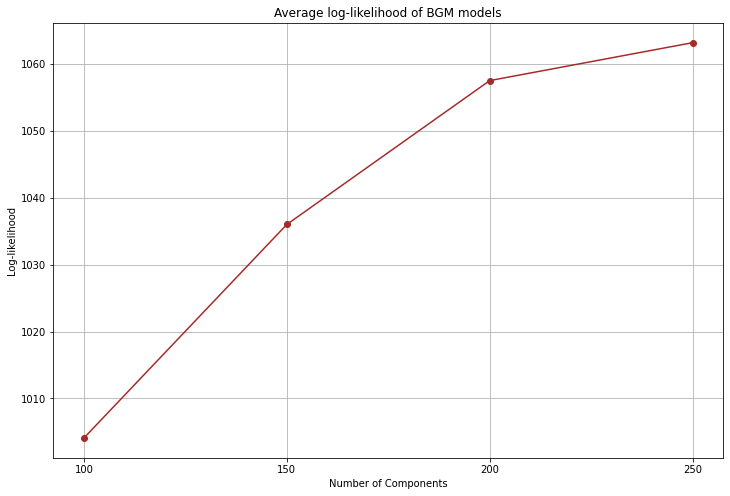

In [169]:
# Plot the log-likelihood
plt.figure(figsize=(12, 8))
plt.plot(n_range, score_list, "-o", color="brown")
plt.xlabel("Number of Components")
plt.ylabel("Log-likelihood")
plt.xticks(n_range)
plt.title("Average log-likelihood of BGM models")
plt.grid()

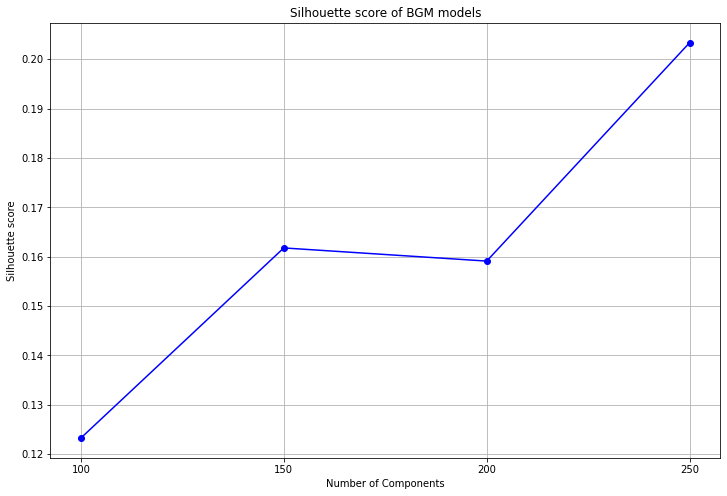

In [170]:
# Plot the Silhouette score
plt.figure(figsize=(12, 8))
plt.plot(n_range, silho_list, "o-", color="blue")
plt.xlabel("Number of Components")
plt.ylabel("Silhouette score")
plt.xticks(n_range)
plt.title("Silhouette score of BGM models")
plt.grid()

In [172]:
# Select the BGM model with highest log-likelihood
best_index = np.argmax(np.asarray(silho_list))
# print(best_index)

# Obtain optimal number of clusters (active components)
threshold = 0.001
active_components = weight_list[best_index] > threshold
# print(active_components)

best_n = active_components.sum()
# best_alpha = best_bgm_estimator.weight_concentration_prior_
print(f"Optimal number of clusters = {best_n}")

Optimal number of clusters = 219


In [173]:
best_bgm_model = build_bgm_model(X, best_n)

Initialization 0
  Iteration 10	 time lapse 543.04415s	 ll change 8149.66859
Initialization converged: True	 time lapse 1062.69304s	 ll 89838830.39471


In [174]:
best_bgm_labels = best_bgm_model.predict(X)

In [183]:
print(np.asarray(best_bgm_model.weights_ > threshold).sum())

198


In [186]:
print(
    best_bgm_model.converged_,
    best_bgm_model.score(X),
    metrics.silhouette_score(X, best_bgm_labels)
)

True 1060.165139785625 0.1647001


In [187]:
# np.vstack(
#     (
#         np.unique(best_bgm_labels, return_counts=True)[0],
#         np.unique(best_bgm_labels, return_counts=True)[1],
#     )
# ).T

In [188]:
pca_datapoint = np.load(OUTPUT_DIR + "pca_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "tsne_datapoints.npy")

Start PCA 2021-04-28 23:20:37.347583
End PCA 2021-04-28 23:20:37.352583
PCA duration 0:00:00.005000

Start t-SNE 2021-04-28 23:20:37.352583
End t-SNE 2021-04-28 23:20:37.358583
t-SNE duration 0:00:00.006000



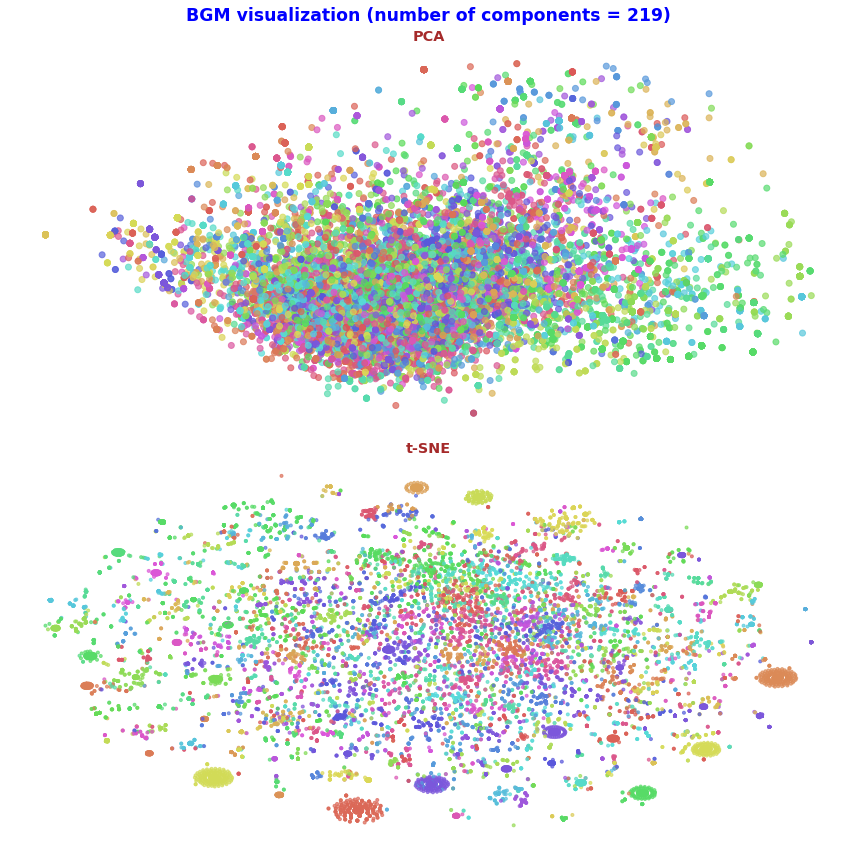

In [193]:
plot_title = f"BGM visualization (number of components = {best_n})"
palette = sns.color_palette("hls", as_cmap=True)
colors = best_bgm_labels / best_n

# Visualize clusters with PCA and t-SNE
visualize_cluster(
    plot_title,
    (12, 12),
    colors,
    palette,
    pca_datapoint,
    tsne_datapoint,
    pca=True,
    tsne=True,
)

## Save cluster results to file

In [190]:
np.save(OUTPUT_DIR + "job-title_bgm-clusters.csv", best_bgm_labels)

In [191]:
np.save(OUTPUT_DIR + "job-title_bgm-clusters_weights.csv", best_bgm_model.weights_)